In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, train_test_split,StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore')
from scipy.stats import randint as sp_randint
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

In [2]:
from sklearn import metrics


In [3]:
# Settings to display all columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

### Data Analysis
 - Load Data
 - Use describe to look for statistics of the data
 - Look for the missing values (No missing values found)
 - All variables are numeric variables

### Data Dictionary
 - Cement (cement) --quantitative --kg in a m3 mixture 
 - Blast Furnace Slag (slag) --quantitative --kg ina m3 mixture
 - Fly Ash (ash) --quantitative --kg ina m3 mixture 
 - Water (water) --quantitative --kg in a m3 mixture
 - Superplasticizer (superplastic) --quantitative --kg in a m3 mixture
 - Coarse Aggregate (coarseagg) --quantitative --kg in a m3 mixture
 - Fine Aggregate (fineagg) --quantitative --kg in a m3 mixture
 - Age(age) --quantitative --Day (1~365) 
 - Concrete compressive strength(strength) --quantitative --MPa 


In [4]:
data = pd.read_csv('concrete.csv')
print("Data shape",data.shape)
data.head()

Data shape (1030, 9)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [5]:
data.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [7]:
data.isna().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

### EDA : Univariate Analysis
 - slag, ash, superplastic and age are not following normal distribution compared to other attributes

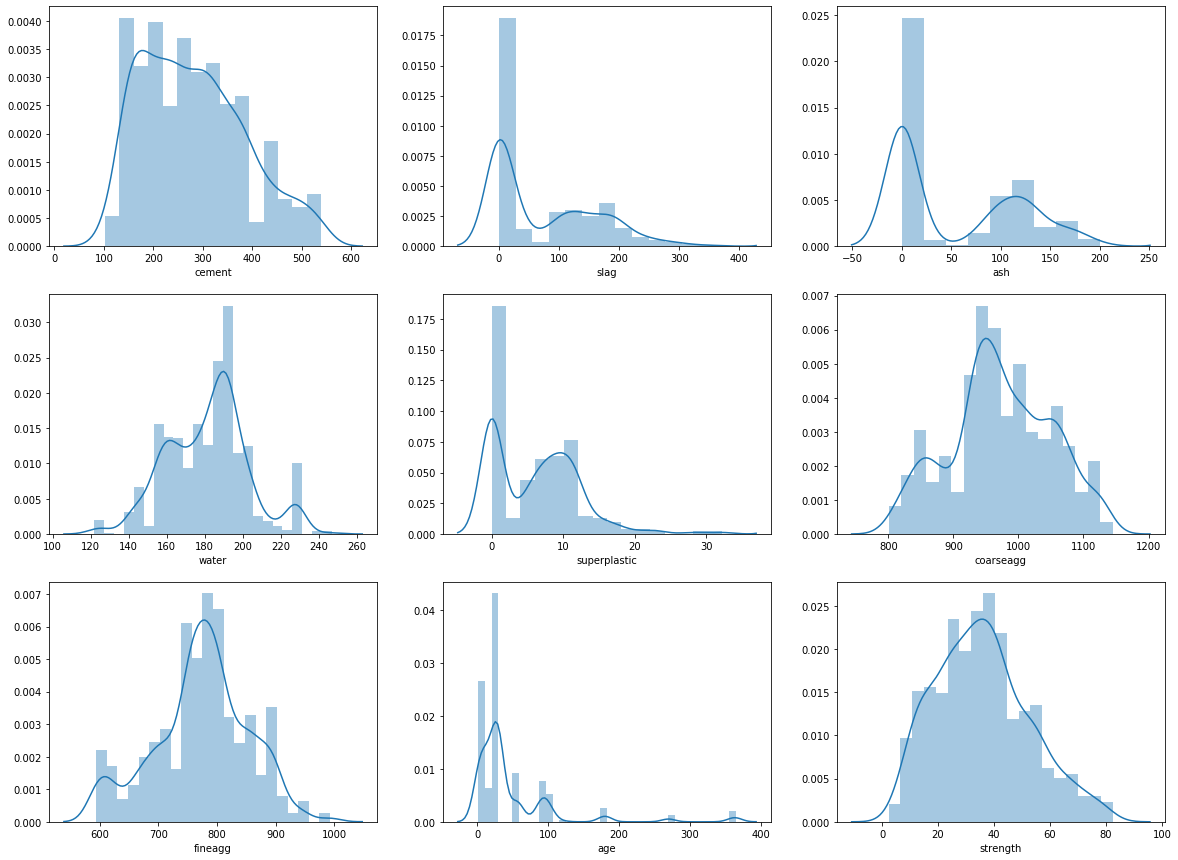

In [8]:
numeric_cols = list(data.select_dtypes(include=[np.number]).columns)
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for variable, subplot in zip(numeric_cols, ax.flatten()):
    sns.distplot(data[variable], ax=subplot)

### Correlation Analysis
 - None of the variables show high correlation with other


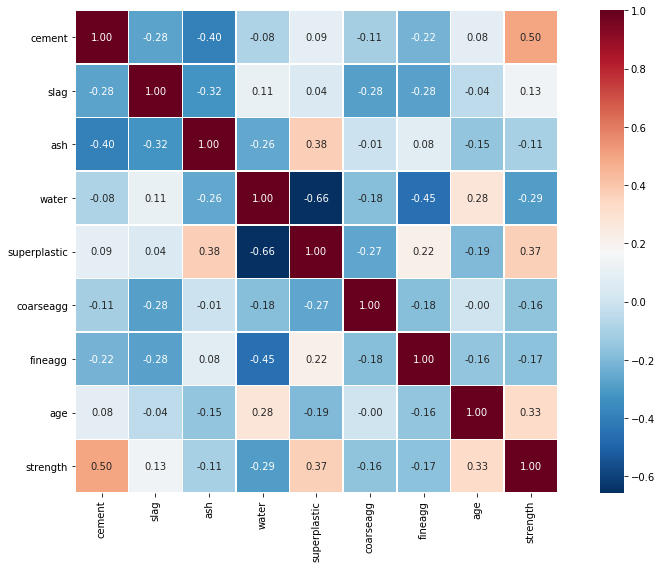

In [9]:
plt.figure(figsize=(12,8))
sns.heatmap(data._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

### Feature Engineering
 - Applying log transformation to age category alone

In [10]:
data['age'] = np.log(data['age'])

#### Model Evaluation
 - Evaluate the regression models with base parameters to see which one performs better using KFold cross validation
 - Since its a regression problem, decided to choose RMSE as the evaluation mechanism
 - Cross Val score has no scoring method as "rmse", hence calculating the mse(which is negative, MSE is a loss function and sklearn design decision was made so that the results are made negative), we are negating that value and taking sqrt to compare the models

In [11]:
X = data.drop('strength',axis=1)
y= data['strength']

In [12]:
models = []
models.append(('LR', LinearRegression()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('Bagging', BaggingRegressor()))
results = []
names = []

for name, model in models:
    kfold_val = KFold(n_splits = 5, random_state = 41)
    cross_val_results =np.sqrt(-cross_val_score(model, X, y, cv = kfold_val,scoring='neg_mean_squared_error'))
    results.append([name,cross_val_results.mean(),cross_val_results.std()])
results = pd.DataFrame(results,columns=['Model','RMSE','RMSE(std)'])
results.head()

,Model,RMSE,RMSE(std)
0,LR,7.158708,0.460824
1,CART,6.594953,0.825939
2,RF,4.914694,0.571418
3,GB,5.177257,0.572668
4,Bagging,5.244081,0.562881


### Model Selection:
 - Gradient Boosting performs comparitively better than base, bagging and RF in terms of RMSE and Standard deviation
 - Hence choosing Gradient boosting and going to perform hyperparameter optimization

### Hyperparameter Optimization
 - GridSearch

In [14]:
gb = GradientBoostingRegressor()

# use a full grid over all parameters
param_grid = {
              "max_depth": [3,5, None],
              "learning_rate": [0.001, 0.01, 0.1],
              "n_estimators": [50,100,150],
              "min_samples_leaf": [1, 3, 10],
              "min_samples_split": [2, 3, 10]
             }
grid_search = GridSearchCV(gb, param_grid=param_grid)
grid_search.fit(X, y)
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [15]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(3, 11),
              "n_estimators": sp_randint(50,150),
              "learning_rate": [0.001,0.01,0.1],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11)
             }
# run randomized search
samples = 10  # number of random samples 
randomCV = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=samples) #default cv = 3
randomCV.fit(X, y)
print(randomCV.best_params_)

{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 124}


In [16]:
gb_random = randomCV.best_estimator_
gb_grid = grid_search.best_estimator_
gb = GradientBoostingRegressor()

In [17]:
final_models = []
final_models.append(('GB_Grid',gb_grid))
final_models.append(('GB_Random', gb_random))
final_models.append(('GB', gb))
final_results =[]
for name, model in final_models:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    print(model)
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r2_result = metrics.r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
#     r2_score = metrics.r2_score(y_test, y_pred)
    final_results.append([name,r2_result, mae,mse, rmse])

final_results = pd.DataFrame(final_results, columns =['Model','R2_Score','MAE','MSE','RMSE',])
final_results

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_sa

,Model,R2_Score,MAE,MSE,RMSE
0,GB_Grid,0.917543,3.029166,21.836830,4.672989
1,GB_Random,0.906123,3.176512,24.861121,4.986093
2,GB,0.877886,4.036066,32.338793,5.686721


### Conclusion
 - In this specific scenario, Gradient boosting with Grid search provides the best parameters and we can achieve RMSE value of 12.4